In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import torch 
from torch import nn, optim
from copy import deepcopy as copy
import pandas as pd

from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
from scipy.stats import wasserstein_distance

In [224]:
plt.rcParams['figure.figsize'] = (10, 7.5)

In [4]:
hidden_dim = 20
embedding_dim = 5
n_tokens = 100
n_tokens_p_sentences = 10
n_sentences = 30
n_clients = 20

w_ie = np.random.normal(0, 1, size=(embedding_dim, n_tokens))
w_eh = np.random.normal(0, 1, size=(hidden_dim, embedding_dim))
w_hh = np.random.normal(0, 1, size=(hidden_dim, hidden_dim))   
w_ho = np.random.normal(0, 1, size=(n_tokens, hidden_dim))

In [5]:
def generate_clients(n_clusters=1, n_sentences = n_sentences, n_tokens_p_setence = n_tokens_p_sentences, n_clients = n_clients):

    clients = []
    for client in range(n_clients):
        tokens = []
        
        init_token = client % n_clusters
        for _ in range(n_sentences):
            hidden = np.zeros(hidden_dim) 
            token_n = init_token
            tokens.append(token_n)
            for _ in range(n_tokens_p_setence - 1):
                one_hot = np.zeros(n_tokens)
                one_hot[token_n] = 1
                embedding = w_ie @ one_hot 
                hidden = np.tanh(w_hh @ hidden + w_eh @ embedding)
                output = w_ho @ hidden 
                softmax = np.exp(output) / np.sum(np.exp(output))
                token_n = np.random.choice(range(n_tokens), p=softmax)
                tokens.append(token_n) 
        clients.append(tokens)
    return torch.tensor(clients).reshape(n_clients, n_sentences, -1)

In [6]:
class RNN(nn.Module):
    
    def __init__(self, n_tokens, embedding_dim, hidden_dim):
        super(RNN, self).__init__()
        self.W_ei = nn.Embedding(n_tokens, embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, nonlinearity='tanh', bias=False)
        self.W_ho = nn.Linear(hidden_dim, n_tokens, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        e = self.W_ei(x)
        hidden, _ = self.rnn(e)
        output = self.softmax(self.W_ho(hidden))
        return output
    

    """
        Utility functions to take average of models
    """
    
    def __add__(self, other):
        my_copy = copy(self)
        with torch.no_grad():
            for self_param, other_param in zip(my_copy.parameters(), other.parameters()):
                self_param.data += other_param.data
        return my_copy
    
    def __truediv__(self, n):
        my_copy = copy(self)
        with torch.no_grad():
            for self_param in my_copy.parameters():
                self_param.data /= n
        return my_copy
    
    def zero(self):
        for self_param in self.parameters():
            self_param.data = torch.zeros_like(self_param.data)
        return self

# 1 Cluster

In [240]:
clients = generate_clients()

In [241]:
loss_fn = nn.NLLLoss()
batch_size = 10
lr = 0.01
n_steps = 1000

In [242]:
all_steps = [[[] for _ in range(n_steps)] for _ in range(n_clients)]
losses = [[] for _ in range(n_clients)]
acc = [[] for _ in range(n_clients)]

final_models = []
for client in range(n_clients):
    print(client)
    model = RNN(n_tokens, embedding_dim, hidden_dim-10, batch_size)
    optimizer = optim.Adam(lr=lr, params=model.parameters())

    for step in range(n_steps):
        for name, param in model.named_parameters():
            all_steps[client][step].extend(list(param.view(-1).detach().numpy()))
        
        batch_idx = np.random.choice(range(n_sentences), batch_size)
        X,Y = clients[client][batch_idx,:-1], clients[client][batch_idx,1:]
        optimizer.zero_grad()
        predict = model(X)
        loss = loss_fn(predict.reshape(-1, n_tokens), Y.reshape(-1))
        loss.backward()
        optimizer.step()
        
        acc[client].append(torch.sum(torch.argmax(predict, dim=2) == Y).item() / (X.shape[0] * X.shape[1]))
        losses[client].append(loss.item())
    final_models.append(model)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


## Data

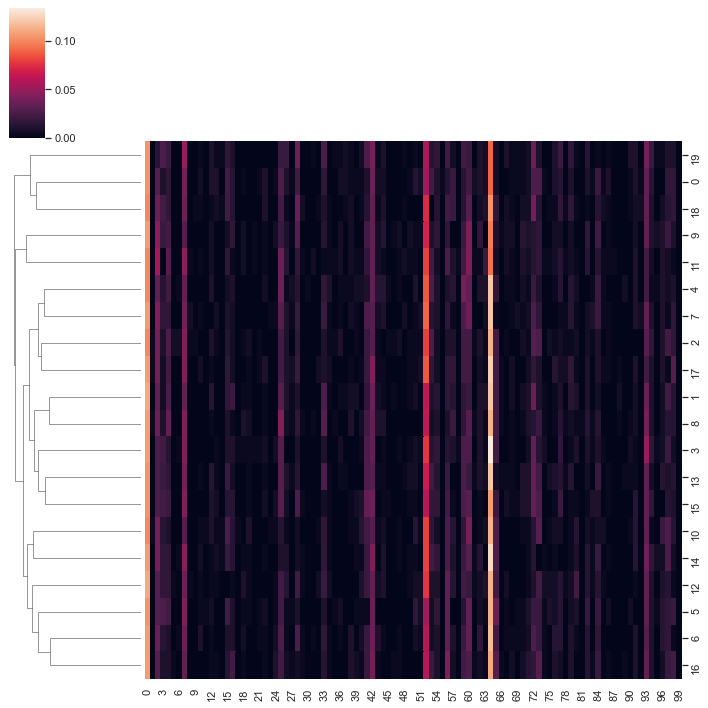

In [32]:
freq = np.zeros((n_clients, n_tokens))
for i in range(n_tokens):
    freq[:,i] = torch.sum(clients == i, dim=[1,2]).detach().numpy()
freq /= (n_sentences * n_tokens_p_sentences)
sns.clustermap(freq, col_cluster=False)
plt.show()

In [167]:
loss_fn = nn.NLLLoss()
n_steps = 1000
batch_size = 10
lr = 0.01

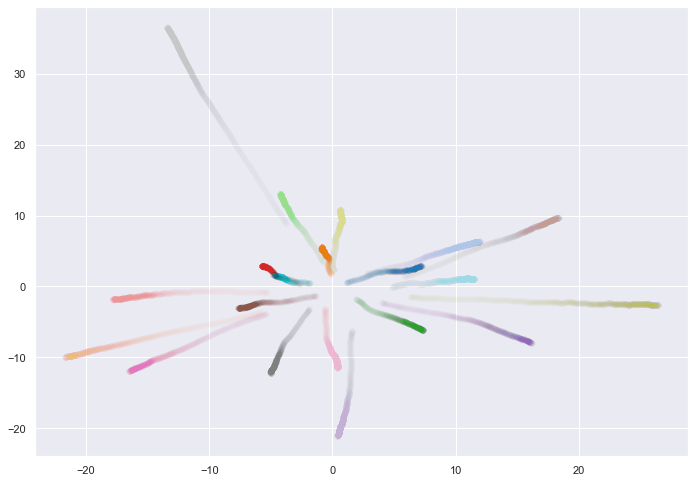

In [169]:
step_matrix = torch.tensor(all_steps).reshape(-1, n_model_params)
pca = PCA(n_components=2)

x = pca.fit_transform(step_matrix)
for i, color in zip(range(n_clients), (plt.get_cmap('tab20').colors * 10)[:n_clients]):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.scatterplot(x[i*n_steps:(i+1)*n_steps,0], x[i*n_steps:(i+1)*n_steps,1],alpha=0.01,color=color, linewidth=0)
#plt.legend()
plt.show()

In [244]:
runs = pd.DataFrame(columns = ['client', 'step', 'loss', 'accuracy'])
runs['client'] = [i for i in range(n_clients) for _ in range(n_steps)]
runs['step'] = list(range(n_steps)) * n_clients
runs['loss'] = np.array(losses).reshape(-1)
runs['loss_smooth'] = np.concatenate([runs['loss'][1000*i:1000*(i+1)].rolling(40).mean() for i in range(0,20)])
runs['accuracy'] = np.array(acc).reshape(-1)
runs['accuracy_smooth'] = runs['accuracy'].rolling(40).mean()

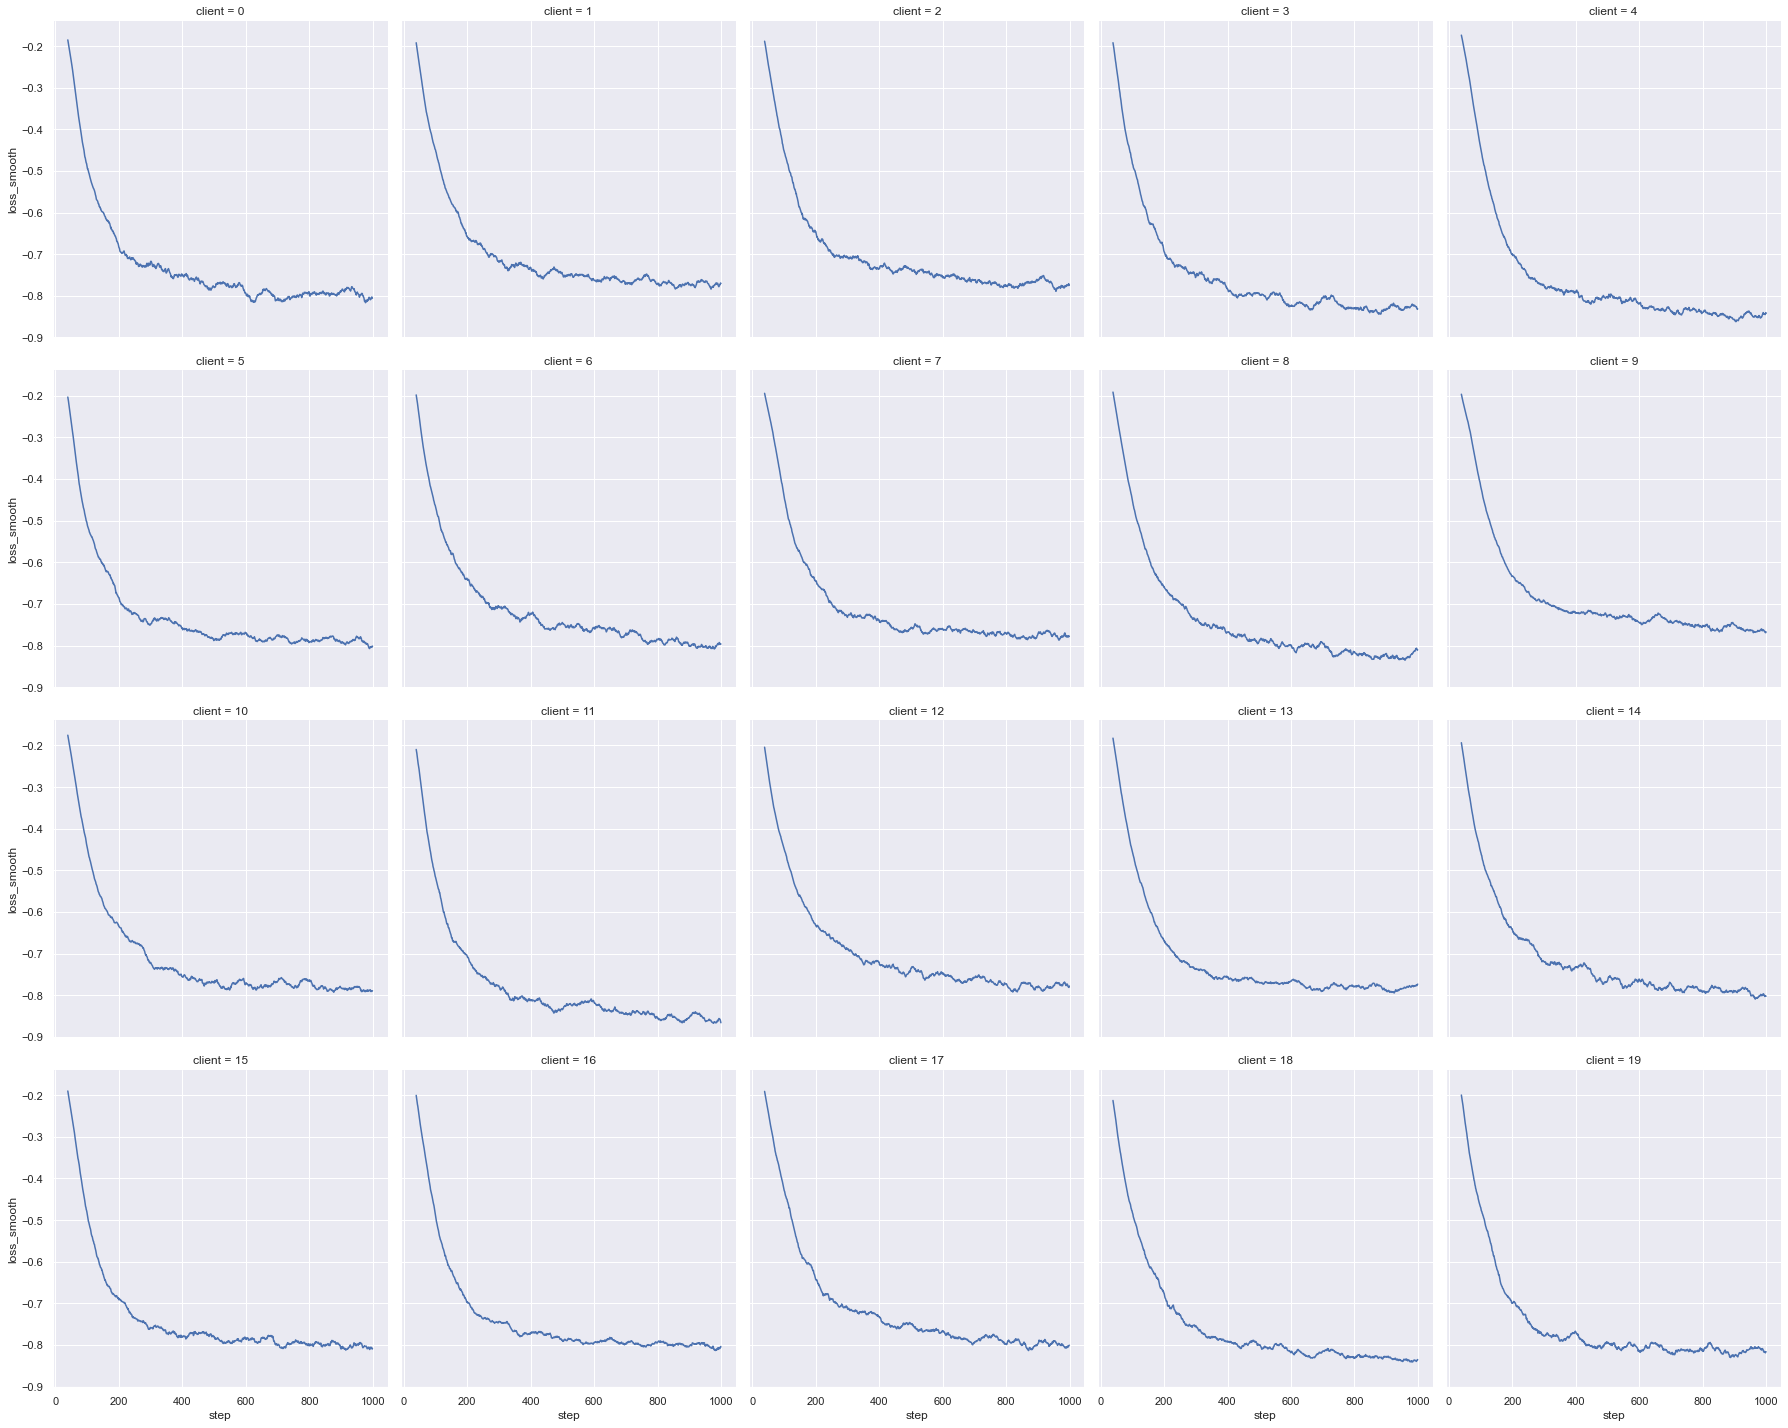

In [246]:
sns.relplot(x="step", y="loss_smooth", col="client", kind="line", data=runs, col_wrap=5)

In [56]:
avg_client_loss = np.mean(runs['loss_smooth'][999::1000])

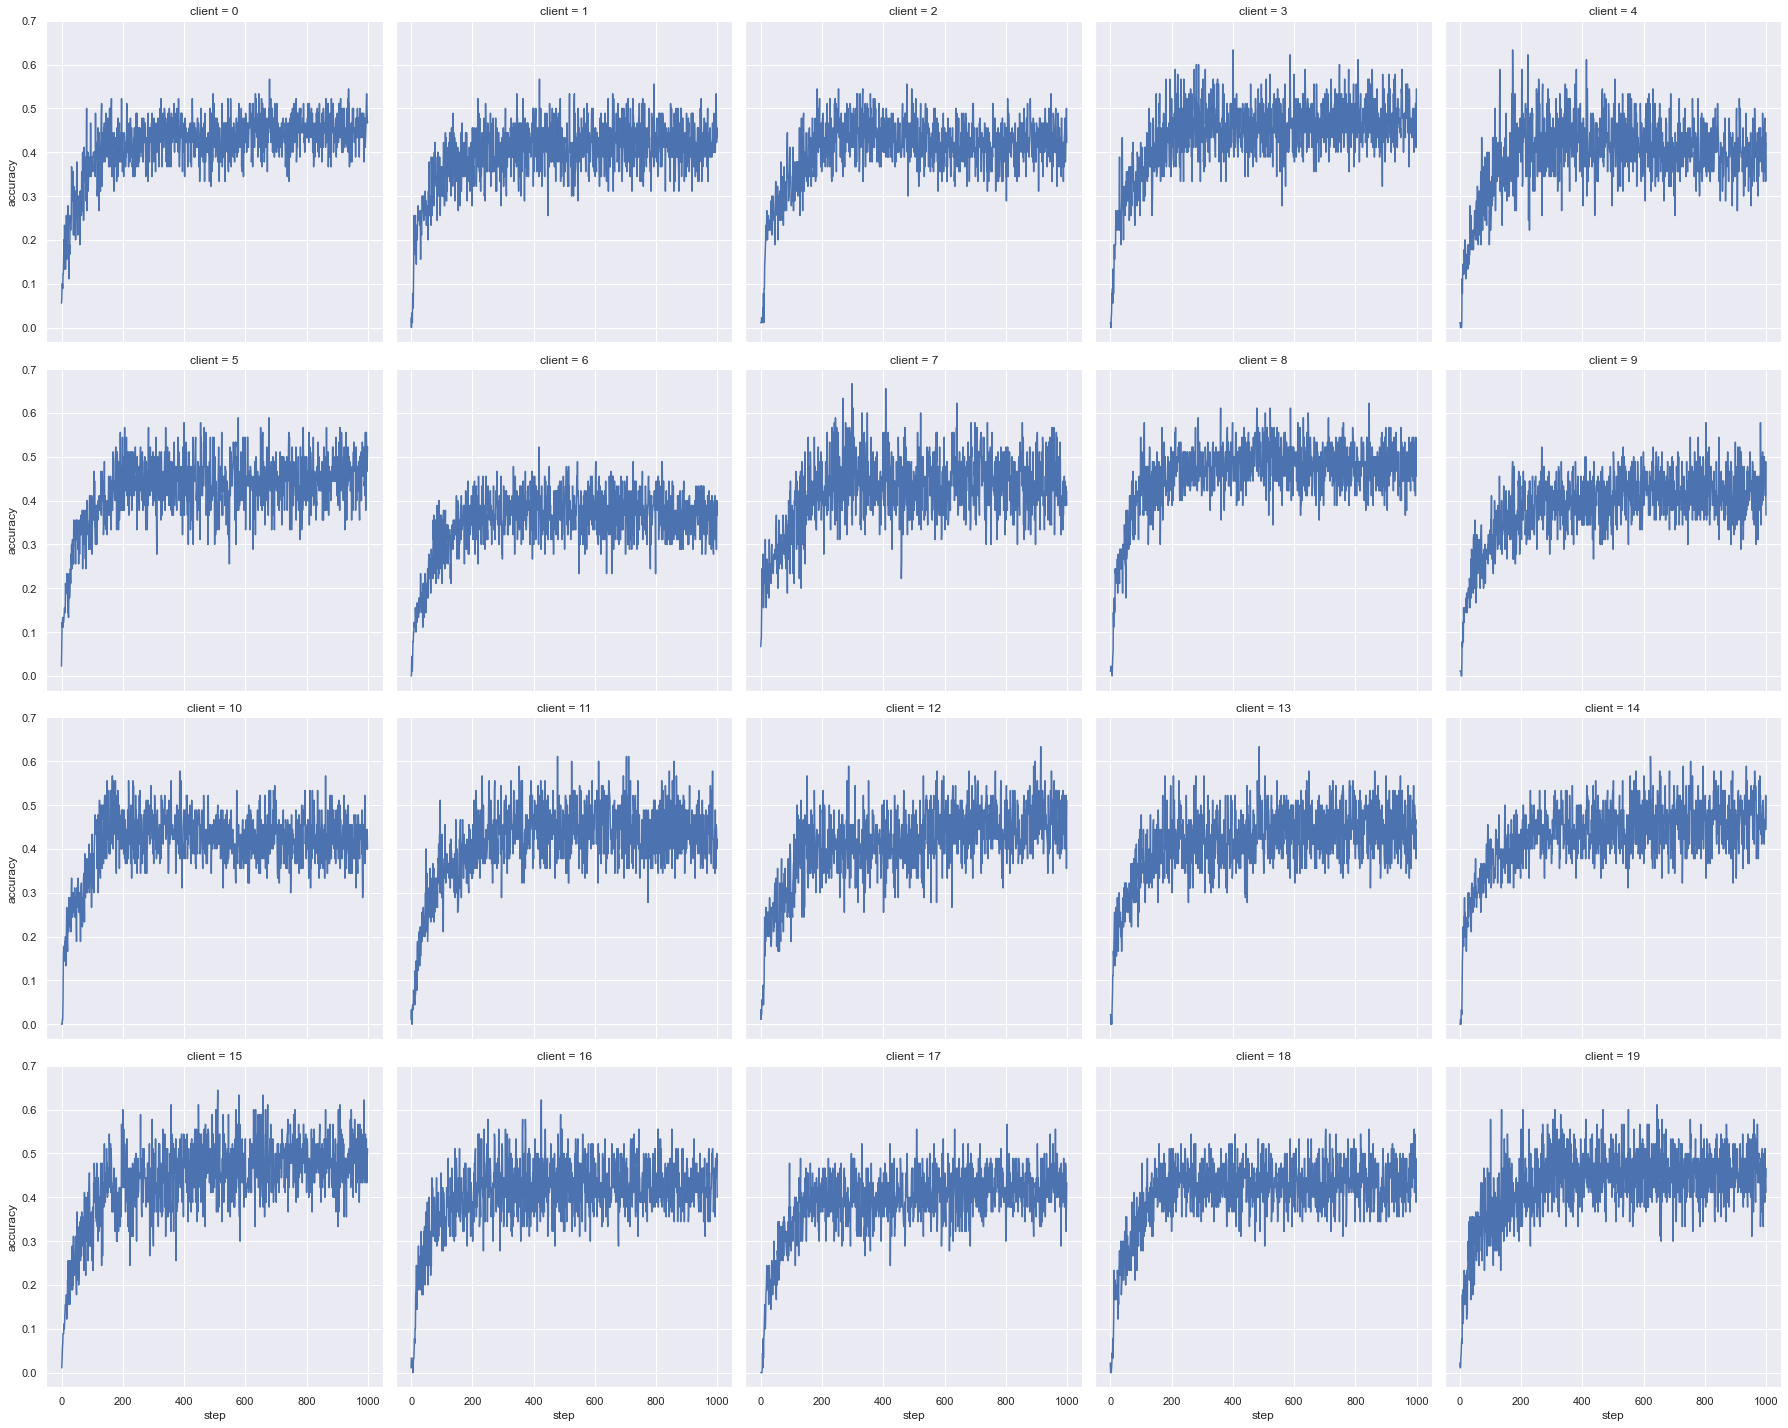

In [38]:
sns.relplot(x="step", y="accuracy", col="client", kind="line", data=runs, col_wrap=5)

In [ ]:
average_

In [239]:
loss_fn = nn.NLLLoss()
n_rounds = 1000
batch_size = 10
lr = 0.1
n_steps = 20

In [240]:
# %%time 
#all_steps = [[[[] for _ in range(n_steps)] for _ in range(n_clients)] for _ in range(n_rounds)]
losses = [[] for _ in range(n_clients)]
acc = [[] for _ in range(n_clients)]

server_model_params = [[] for _ in range(n_rounds+1)]
model_per_round = []
server_model_losses = []

server_model = RNN(n_tokens, embedding_dim, hidden_dim, batch_size)
zero_model = copy(server_model).zero()

for name, param in server_model.named_parameters():
    server_model_params[0].extend(list(param.view(-1).detach().numpy()))
model_per_round.append(copy(server_model))
    
for round in range(n_rounds):
    client_models = []
    server_model_loss = 0
    for client in range(n_clients):
        client_model = copy(server_model)
        optimizer = optim.Adam(lr=lr, params=client_model.parameters())
        for step in range(n_steps):
            optimizer.zero_grad()
            # log params
#             for name, param in client_model.named_parameters():
#                 all_steps[round][client][step].extend(list(param.view(-1).detach().numpy()))
                
            # step of sgd
            batch_idx = np.random.choice(range(n_sentences), batch_size)
            X,Y = clients[client][batch_idx,:-1], clients[client][batch_idx,1:]
            optimizer.zero_grad()
            predict = client_model(X)
            loss = loss_fn(predict.reshape(-1, n_tokens), Y.reshape(-1))
            loss.backward()
            optimizer.step()
            # log metricst
            if step == 0:
                server_model_loss += loss
    
            acc[client].append(torch.sum(torch.argmax(predict, dim=2) == Y).item() / (X.shape[0] * X.shape[1]))
            losses[client].append(loss.item())
        client_models.append(client_model)

    server_model_losses.append(server_model_loss / n_clients)
    # average model
    server_model = sum(client_models, zero_model) / n_clients
    model_per_round.append(copy(server_model))
    for name, param in server_model.named_parameters():
        server_model_params[round+1].extend(list(param.view(-1).detach().numpy()))

In [241]:
server_model_losses_lr_0_1_s_20= server_model_losses

In [73]:
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

## Lr = 0.1

In [283]:
n_clusters = 1
lr = '0_1'
exps = [np.load('cluster_{}/lr_{}_s_1.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_2.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_5.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_10.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_20.npy'.format(n_clusters,lr), allow_pickle=True)]
omega = np.zeros((5, 901))
for i, exp in enumerate(exps):
    omega[i] = moving_average(exp, n=100) - avg_client_loss
plt.contourf(range(901), [1,2,5,10,20], omega, levels=np.arange(0.1,0.8,0.05))
c = plt.colorbar()
c.ax.set_title('$ \Omega $', )
plt.xlabel('Round')
plt.ylabel('Client Steps')
plt.yticks([1,2,5,10,20])
plt.savefig('c{}lr{}.png'.format(n_clusters,lr))
plt.clf()
for steps, exp in zip([1,2,5,10,20],exps):
    plt.plot(moving_average(exp, n=100) - avg_client_loss, label='{} Client Steps'.format(steps))
plt.legend()
plt.xlabel('Round')
plt.ylabel('$ \Omega $')
plt.savefig('c{}lr{}p.png'.format(n_clusters,lr))
plt.clf()

<Figure size 720x540 with 0 Axes>

## Lr = 0.01

In [282]:
n_clusters = 1
lr = '0_01'
exps = [np.load('cluster_{}/lr_{}_s_1.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_2.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_5.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_10.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_20.npy'.format(n_clusters,lr), allow_pickle=True)]
omega = np.zeros((5, 901))
for i, exp in enumerate(exps):
    omega[i] = moving_average(exp, n=100) - avg_client_loss
plt.contourf(range(901), [1,2,5,10,20], omega, levels=np.arange(0.1,0.8,0.05))
c = plt.colorbar()
c.ax.set_title('$ \Omega $', )
plt.xlabel('Round')
plt.ylabel('Client Steps')
plt.yticks([1,2,5,10,20])
plt.savefig('c{}lr{}.png'.format(n_clusters,lr))
plt.clf()
for steps, exp in zip([1,2,5,10,20],exps):
    plt.plot(moving_average(exp, n=100) - avg_client_loss, label='{} Client Steps'.format(steps))
plt.legend()
plt.xlabel('Round')
plt.ylabel('$ \Omega $')
plt.savefig('c{}lr{}p.png'.format(n_clusters,lr))
plt.clf()

<Figure size 720x540 with 0 Axes>

### lr = 0.001

In [281]:
n_clusters = 1
lr = '0_001'
exps = [np.load('cluster_{}/lr_{}_s_1.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_2.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_5.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_10.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_20.npy'.format(n_clusters,lr), allow_pickle=True)]
omega = np.zeros((5, 901))
for i, exp in enumerate(exps):
    omega[i] = moving_average(exp, n=100) - avg_client_loss
plt.contourf(range(901), [1,2,5,10,20], omega, levels=np.arange(0.1,0.8,0.05))
c = plt.colorbar()
c.ax.set_title('$ \Omega $', )
plt.xlabel('Round')
plt.ylabel('Client Steps')
plt.yticks([1,2,5,10,20])
plt.savefig('c{}lr{}.png'.format(n_clusters,lr))
plt.clf()
for steps, exp in zip([1,2,5,10,20],exps):
    plt.plot(moving_average(exp, n=100) - avg_client_loss, label='{} Client Steps'.format(steps))
plt.legend()
plt.xlabel('Round')
plt.ylabel('$ \Omega $')
plt.savefig('c{}lr{}p.png'.format(n_clusters,lr))
plt.clf()

<Figure size 720x540 with 0 Axes>

# 2 Clusters

In [340]:
n_clusters = 2

clients = generate_clients(n_clusters=n_clusters)

### Data

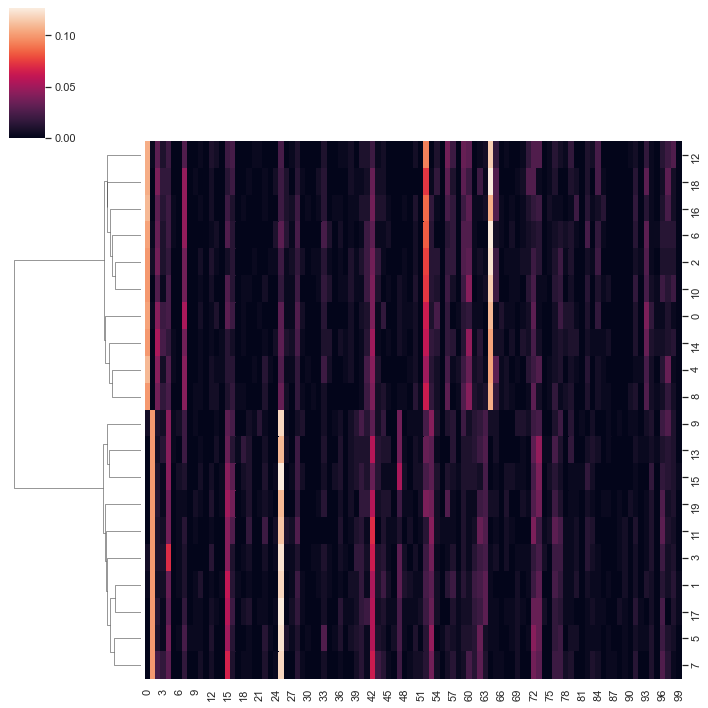

In [341]:
freq = np.zeros((n_clients, n_tokens))
for i in range(n_tokens):
    freq[:,i] = torch.sum(clients == i, dim=[1,2]).detach().numpy()
freq /= (n_sentences * n_tokens_p_sentences)
sns.clustermap(freq, col_cluster=False)
plt.show()

### Local SGD

In [342]:
loss_fn = nn.NLLLoss()
n_steps = 1000
batch_size = 10
lr = 0.01

In [343]:
all_steps = [[[] for _ in range(n_steps)] for _ in range(n_clients)]
losses = [[] for _ in range(n_clients)]
acc = [[] for _ in range(n_clients)]

final_models = []
for client in range(n_clients):
    model = RNN(n_tokens, embedding_dim, hidden_dim-10, batch_size)
    optimizer = optim.Adam(lr=lr, params=model.parameters())

    for step in range(n_steps):
        for name, param in model.named_parameters():
            all_steps[client][step].extend(list(param.view(-1).detach().numpy()))
        
        batch_idx = np.random.choice(range(n_sentences), batch_size)
        X,Y = clients[client][batch_idx,:-1], clients[client][batch_idx,1:]
        optimizer.zero_grad()
        predict = model(X)
        loss = loss_fn(predict.reshape(-1, n_tokens), Y.reshape(-1))
        loss.backward()
        optimizer.step()
        
        acc[client].append(torch.sum(torch.argmax(predict, dim=2) == Y).item() / (X.shape[0] * X.shape[1]))
        losses[client].append(loss.item())
    final_models.append(model)

In [133]:
runs = pd.DataFrame(columns = ['client', 'step', 'loss', 'accuracy'])
runs['client'] = [i for i in range(n_clients) for _ in range(n_steps)]
runs['step'] = list(range(n_steps)) * n_clients
runs['loss'] = np.array(losses).reshape(-1)
runs['loss_smooth'] = np.concatenate([runs['loss'][1000*i:1000*(i+1)].rolling(40).mean() for i in range(0,20)])
runs['accuracy'] = np.array(acc).reshape(-1)

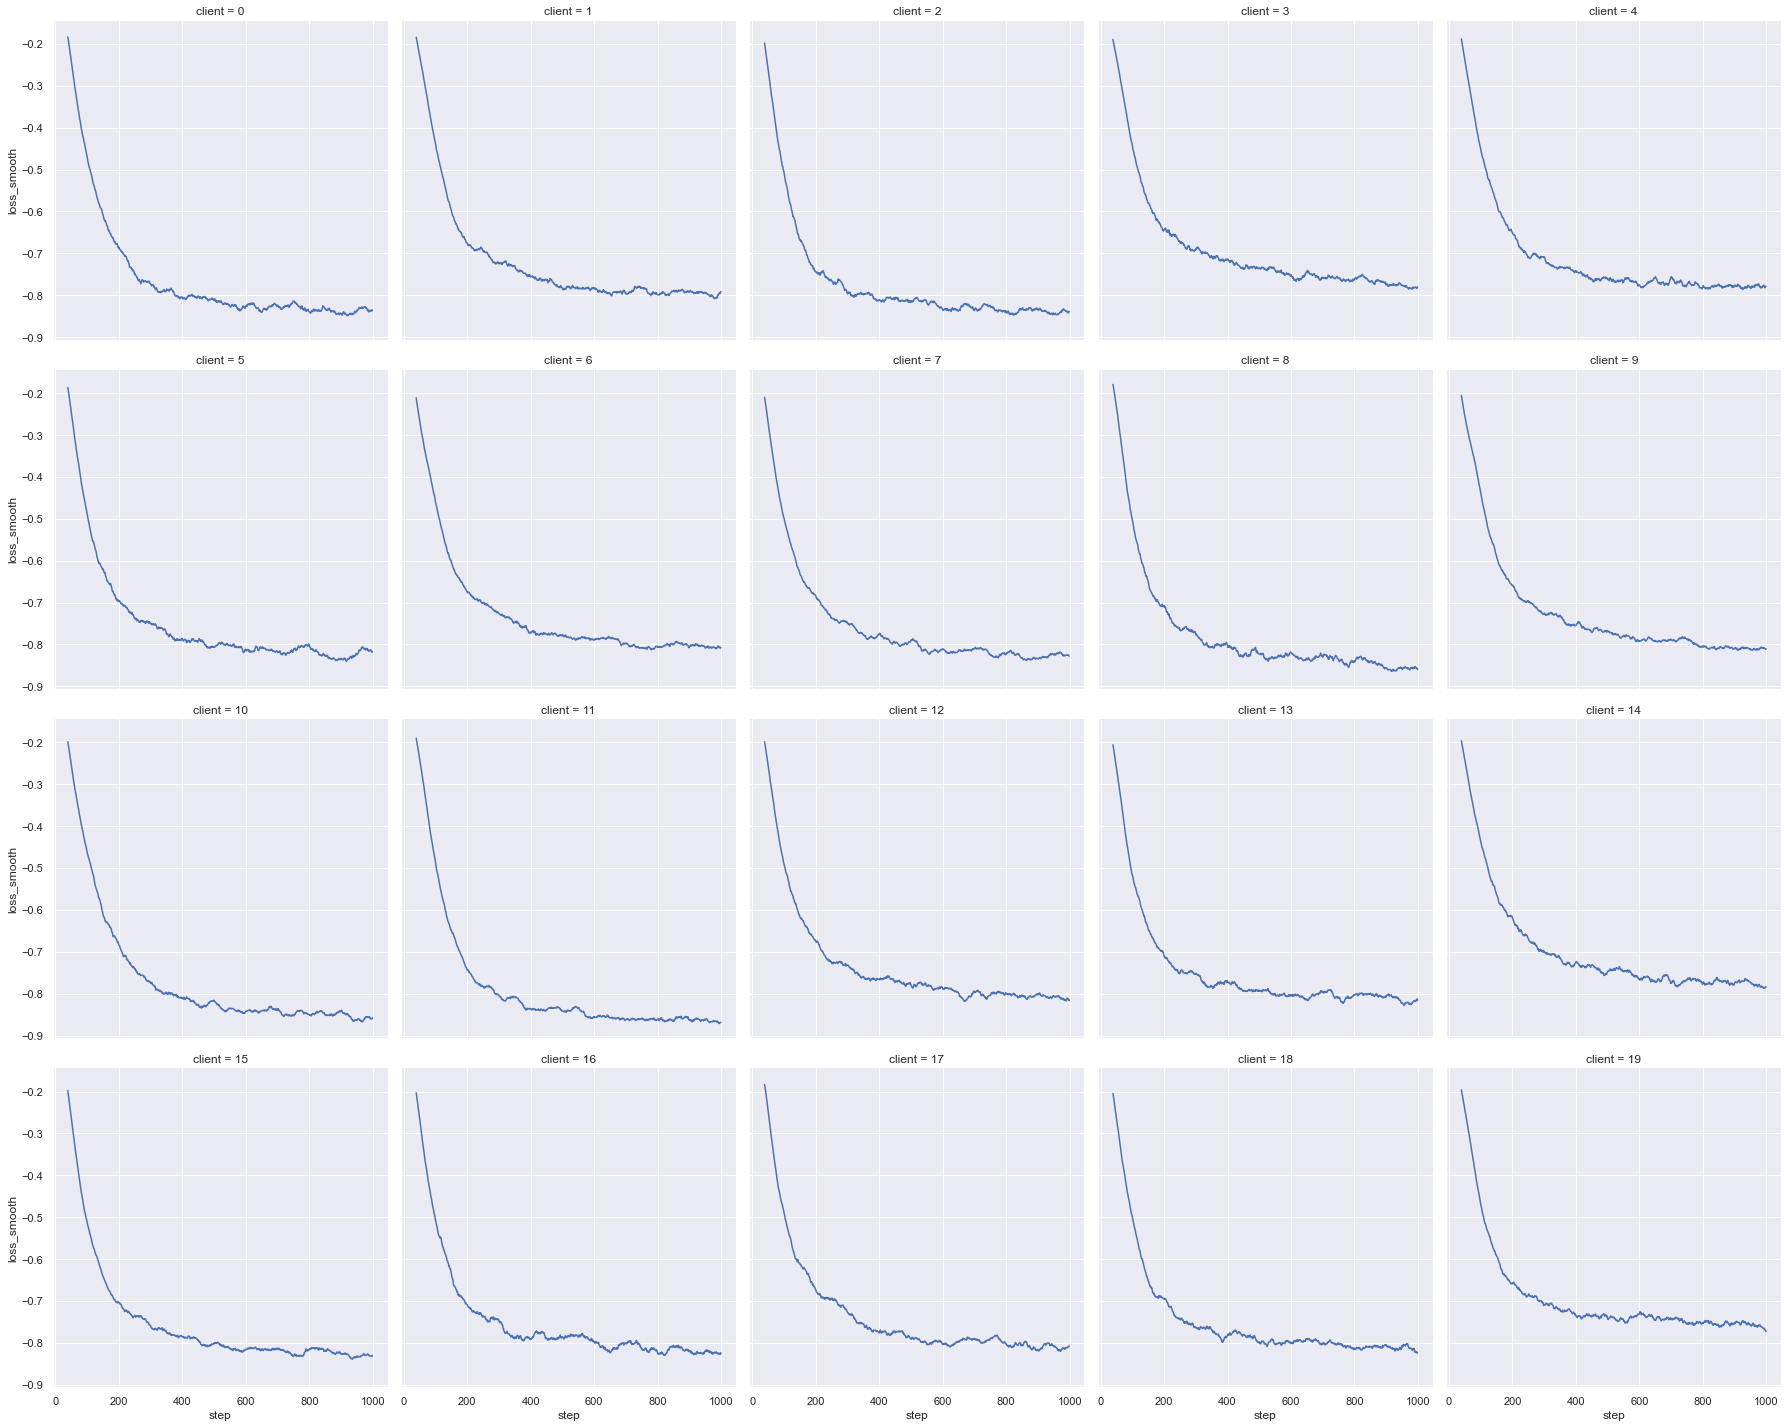

In [134]:
sns.relplot(x="step", y="loss_smooth", col="client", kind="line", data=runs, col_wrap=5)

In [135]:
avg_client_loss = np.mean(runs['loss_smooth'][999::1000])

## FedAvg

In [182]:
loss_fn = nn.NLLLoss()
n_rounds = 1000
batch_size = 10
lr = 0.1
n_steps = 10

In [ ]:
# %%time 
#all_steps = [[[[] for _ in range(n_steps)] for _ in range(n_clients)] for _ in range(n_rounds)]
losses = [[] for _ in range(n_clients)]
acc = [[] for _ in range(n_clients)]

server_model_params = [[] for _ in range(n_rounds+1)]
model_per_round = []
server_model_losses = []

server_model = RNN(n_tokens, embedding_dim, hidden_dim, batch_size)
zero_model = copy(server_model).zero()

for name, param in server_model.named_parameters():
    server_model_params[0].extend(list(param.view(-1).detach().numpy()))
model_per_round.append(copy(server_model))
    
for round in range(n_rounds):
    print(round)
    client_models = []
    server_model_loss = 0
    for client in range(n_clients):
        client_model = copy(server_model)
        optimizer = optim.Adam(lr=lr, params=client_model.parameters())
        for step in range(n_steps):
            optimizer.zero_grad()
            # log params
#             for name, param in client_model.named_parameters():
#                 all_steps[round][client][step].extend(list(param.view(-1).detach().numpy()))
                
            # step of sgd
            batch_idx = np.random.choice(range(n_sentences), batch_size)
            X,Y = clients[client][batch_idx,:-1], clients[client][batch_idx,1:]
            optimizer.zero_grad()
            predict = client_model(X)
            loss = loss_fn(predict.reshape(-1, n_tokens), Y.reshape(-1))
            loss.backward()
            optimizer.step()
            # log metricst
            if step == 0:
                server_model_loss += loss
    
            acc[client].append(torch.sum(torch.argmax(predict, dim=2) == Y).item() / (X.shape[0] * X.shape[1]))
            losses[client].append(loss.item())
        client_models.append(client_model)

    server_model_losses.append(server_model_loss / n_clients)
    # average model
    server_model = sum(client_models, zero_model) / n_clients
    model_per_round.append(copy(server_model))
    for name, param in server_model.named_parameters():
        server_model_params[round+1].extend(list(param.view(-1).detach().numpy()))

In [181]:
server_model_losses_lr_0_1_s_5 = server_model_losses

In [147]:
n_model_params = sum([param.reshape(-1).shape[0] for param in model.parameters()])

## Lr = 0.1

In [280]:
n_clusters = 2
lr = '0_1'
exps = [np.load('cluster_{}/lr_{}_s_1.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_2.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_5.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_10.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_20.npy'.format(n_clusters,lr), allow_pickle=True)]
omega = np.zeros((5, 901))
for i, exp in enumerate(exps):
    omega[i] = moving_average(exp, n=100) - avg_client_loss
plt.contourf(range(901), [1,2,5,10,20], omega, levels=np.arange(0.1,0.8,0.05))
c = plt.colorbar()
c.ax.set_title('$ \Omega $', )
plt.xlabel('Round')
plt.ylabel('Client Steps')
plt.yticks([1,2,5,10,20])
plt.savefig('c{}lr{}.png'.format(n_clusters,lr))
plt.clf()
for steps, exp in zip([1,2,5,10,20],exps):
    plt.plot(moving_average(exp, n=100) - avg_client_loss, label='{} Client Steps'.format(steps))
plt.legend()
plt.xlabel('Round')
plt.ylabel('$ \Omega $')
plt.savefig('c{}lr{}p.png'.format(n_clusters,lr))
plt.clf()

<Figure size 720x540 with 0 Axes>

## lr = 0.01

In [279]:
n_clusters = 2
lr = '0_01'
exps = [np.load('cluster_{}/lr_{}_s_1.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_2.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_5.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_10.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_20.npy'.format(n_clusters,lr), allow_pickle=True)]
omega = np.zeros((5, 901))
for i, exp in enumerate(exps):
    omega[i] = moving_average(exp, n=100) - avg_client_loss
plt.contourf(range(901), [1,2,5,10,20], omega, levels=np.arange(0.1,0.8,0.05))
c = plt.colorbar()
c.ax.set_title('$ \Omega $', )
plt.xlabel('Round')
plt.ylabel('Client Steps')
plt.yticks([1,2,5,10,20])
plt.savefig('c{}lr{}.png'.format(n_clusters,lr))
plt.clf()
for steps, exp in zip([1,2,5,10,20],exps):
    plt.plot(moving_average(exp, n=100) - avg_client_loss, label='{} Client Steps'.format(steps))
plt.legend()
plt.xlabel('Round')
plt.ylabel('$ \Omega $')
plt.savefig('c{}lr{}p.png'.format(n_clusters,lr))
plt.clf()

<Figure size 720x540 with 0 Axes>

## Lr = 0.001

In [278]:
n_clusters = 2
lr = '0_001'
exps = [np.load('cluster_{}/lr_{}_s_1.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_2.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_5.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_10.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_20.npy'.format(n_clusters,lr), allow_pickle=True)]
omega = np.zeros((5, 901))
for i, exp in enumerate(exps):
    omega[i] = moving_average(exp, n=100) - avg_client_loss
plt.contourf(range(901), [1,2,5,10,20], omega, levels=np.arange(0.1,0.8,0.05))
c = plt.colorbar()
c.ax.set_title('$ \Omega $', )
plt.xlabel('Round')
plt.ylabel('Client Steps')
plt.yticks([1,2,5,10,20])
plt.savefig('c{}lr{}.png'.format(n_clusters,lr))
plt.clf()
for steps, exp in zip([1,2,5,10,20],exps):
    plt.plot(moving_average(exp, n=100) - avg_client_loss, label='{} Client Steps'.format(steps))
plt.legend()
plt.xlabel('Round')
plt.ylabel('$ \Omega $')
plt.savefig('c{}lr{}p.png'.format(n_clusters,lr))
plt.clf()

<Figure size 720x540 with 0 Axes>

# 10 Clusters

In [148]:
n_clusters = 10

clients = generate_clients(n_clusters=n_clusters)

## Data

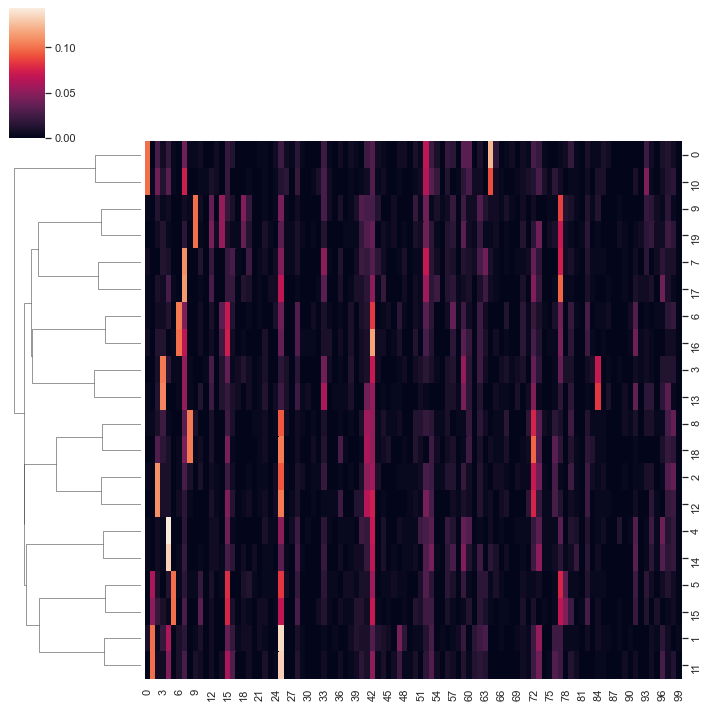

In [149]:
freq = np.zeros((n_clients, n_tokens))
for i in range(n_tokens):
    freq[:,i] = torch.sum(clients == i, dim=[1,2]).detach().numpy()
freq /= (n_sentences * n_tokens_p_sentences)
sns.clustermap(freq, col_cluster=False)
plt.show()

## Local SGD Benchmark

In [150]:
loss_fn = nn.NLLLoss()
n_steps = 1000
batch_size = 10
lr = 0.01

In [151]:
%%time 
all_steps = [[[] for _ in range(n_steps)] for _ in range(n_clients)]
losses = [[] for _ in range(n_clients)]
acc = [[] for _ in range(n_clients)]

final_models = []
for client in range(n_clients):
    model = RNN(n_tokens, embedding_dim, hidden_dim-10, batch_size)
    optimizer = optim.Adam(lr=lr, params=model.parameters())

    for step in range(n_steps):
     
        batch_idx = np.random.choice(range(n_sentences), batch_size)
        X,Y = clients[client][batch_idx,:-1], clients[client][batch_idx,1:]
        optimizer.zero_grad()
        predict = model(X)
        loss = loss_fn(predict.reshape(-1, n_tokens), Y.reshape(-1))
        loss.backward()
        optimizer.step()
        
        acc[client].append(torch.sum(torch.argmax(predict, dim=2) == Y).item() / (X.shape[0] * X.shape[1]))
        losses[client].append(loss.item())
    final_models.append(model)

CPU times: user 50.1 s, sys: 1.62 s, total: 51.7 s
Wall time: 56.5 s


In [152]:
runs = pd.DataFrame(columns = ['client', 'step', 'loss', 'accuracy'])
runs['client'] = [i for i in range(n_clients) for _ in range(n_steps)]
runs['step'] = list(range(n_steps)) * n_clients
runs['loss'] = np.array(losses).reshape(-1)
runs['loss_smooth'] = np.concatenate([runs['loss'][1000*i:1000*(i+1)].rolling(40).mean() for i in range(0,20)])
runs['accuracy'] = np.array(acc).reshape(-1)
runs['accuracy_smooth'] = runs['accuracy'].rolling(40).mean()

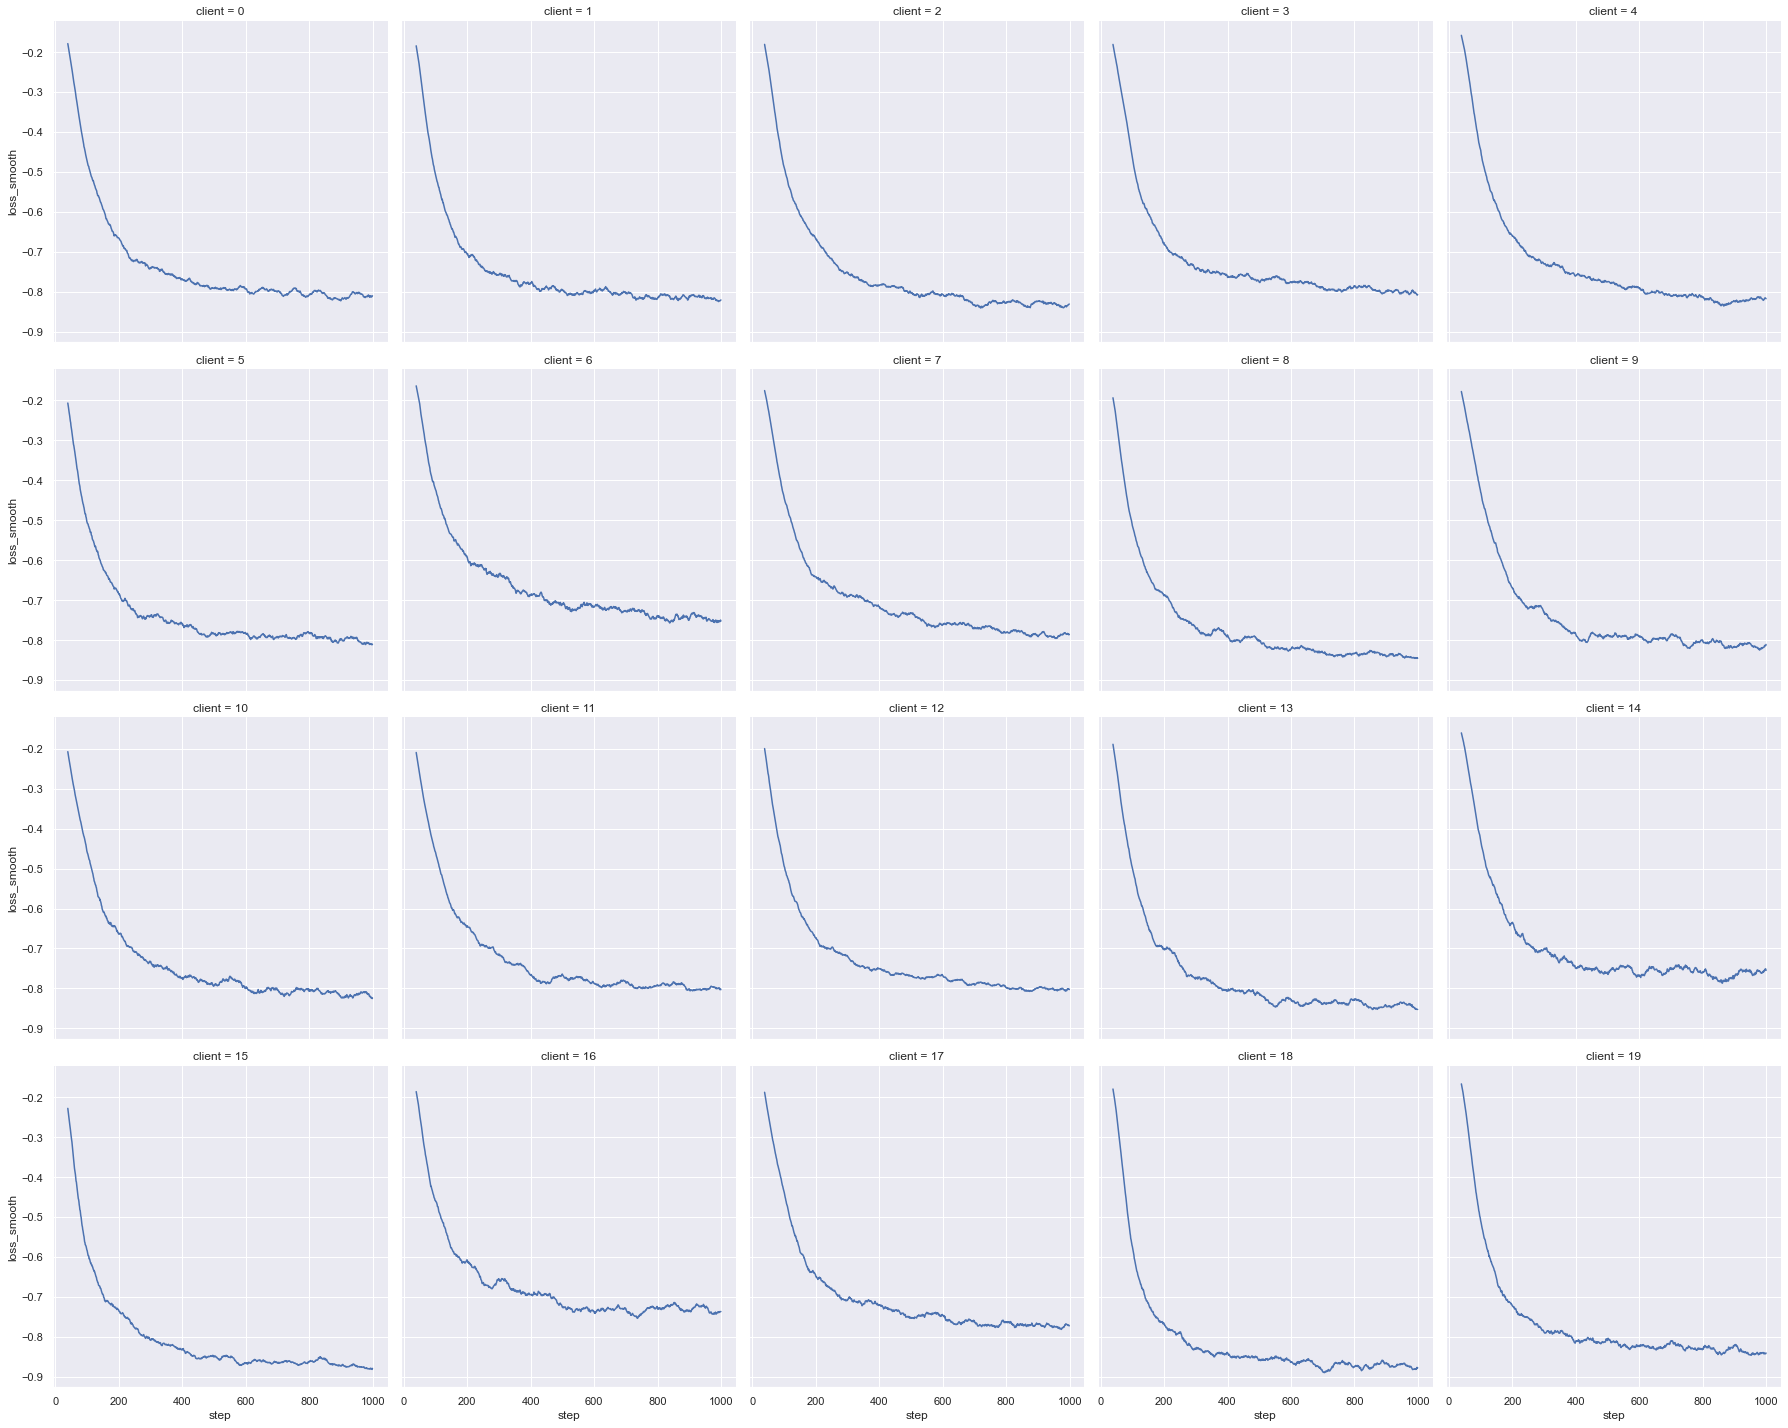

In [153]:
sns.relplot(x="step", y="loss_smooth", col="client", kind="line", data=runs, col_wrap=5)

In [154]:
avg_client_loss = np.mean(runs['loss_smooth'][999::1000])

## FedAvg

In [13]:
loss_fn = nn.NLLLoss()
batch_size = 10
n_rounds = 1000
n_steps = 1
lr = 0.001

In [147]:
%%time 
all_steps = [[[[] for _ in range(n_steps)] for _ in range(n_clients)] for _ in range(n_rounds)]
print('hi')
losses = [[] for _ in range(n_clients)]
print('hi')
acc = [[] for _ in range(n_clients)]
print('hi')

server_model_params = [[] for _ in range(n_rounds+1)]
model_per_round = []
server_model_losses = []
print('hi')

server_model = RNN(n_tokens, embedding_dim, hidden_dim, batch_size)
zero_model = copy(server_model).zero()
print('hi')

for name, param in server_model.named_parameters():
    server_model_params[0].extend(list(param.view(-1).detach().numpy()))
model_per_round.append(copy(server_model))
print('hi')
    
for round in range(n_rounds):
    print(round)
    client_models = []
    server_model_loss = 0
    for client in range(n_clients):
        client_model = copy(server_model)
        optimizer = optim.Adam(lr=lr, params=client_model.parameters())
        for step in range(n_steps):
            optimizer.zero_grad()
            # log params
            for name, param in client_model.named_parameters():
                all_steps[round][client][step].extend(list(param.view(-1).detach().numpy()))
                
            # step of sgd
            batch_idx = np.random.choice(range(n_sentences), batch_size)
            X,Y = clients[client][batch_idx,:-1], clients[client][batch_idx,1:]
            optimizer.zero_grad()
            predict = client_model(X)
            loss = loss_fn(predict.reshape(-1, n_tokens), Y.reshape(-1))
            loss.backward()
            optimizer.step()
            # log metrics
            if step == 0:
                server_model_loss += loss
    
            acc[client].append(torch.sum(torch.argmax(predict, dim=2) == Y).item() / (X.shape[0] * X.shape[1]))
            losses[client].append(loss.item())
        client_models.append(client_model)

    server_model_losses.append(server_model_loss / n_clients)
    # average model
    server_model = sum(client_models, zero_model) / n_clients
    model_per_round.append(copy(server_model))
    for name, param in server_model.named_parameters():
        server_model_params[round+1].extend(list(param.view(-1).detach().numpy()))

hi
hi
hi
hi
hi
hi
0


KeyboardInterrupt: 

## Lr = 0.1

In [277]:
n_clusters = 10
lr = '0_1'
exps = [np.load('cluster_{}/lr_{}_s_1.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_2.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_5.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_10.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_20.npy'.format(n_clusters,lr), allow_pickle=True)]
omega = np.zeros((5, 901))
for i, exp in enumerate(exps):
    omega[i] = moving_average(exp, n=100) - avg_client_loss
plt.contourf(range(901), [1,2,5,10,20], omega, levels=np.arange(0.1,0.8,0.05))
c = plt.colorbar()
c.ax.set_title('$ \Omega $', )
plt.xlabel('Round')
plt.ylabel('Client Steps')
plt.yticks([1,2,5,10,20])
plt.savefig('c{}lr{}.png'.format(n_clusters,lr))
plt.clf()
for steps, exp in zip([1,2,5,10,20],exps):
    plt.plot(moving_average(exp, n=100) - avg_client_loss, label='{} Client Steps'.format(steps))
plt.legend()
plt.xlabel('Round')
plt.ylabel('$ \Omega $')
plt.savefig('c{}lr{}p.png'.format(n_clusters,lr))
plt.clf()

<Figure size 720x540 with 0 Axes>

## Lr = 0.01

In [276]:
n_clusters = 10
lr = '0_01'
exps = [np.load('cluster_{}/lr_{}_s_1.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_2.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_5.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_10.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_20.npy'.format(n_clusters,lr), allow_pickle=True)]
omega = np.zeros((5, 901))
for i, exp in enumerate(exps):
    omega[i] = moving_average(exp, n=100) - avg_client_loss
plt.contourf(range(901), [1,2,5,10,20], omega, levels=np.arange(0.1,0.8,0.05))
c = plt.colorbar()
c.ax.set_title('$ \Omega $', )
plt.xlabel('Round')
plt.ylabel('Client Steps')
plt.yticks([1,2,5,10,20])
plt.savefig('c{}lr{}.png'.format(n_clusters,lr))
plt.clf()
for steps, exp in zip([1,2,5,10,20],exps):
    plt.plot(moving_average(exp, n=100) - avg_client_loss, label='{} Client Steps'.format(steps))
plt.legend()
plt.xlabel('Round')
plt.ylabel('$ \Omega $')
plt.savefig('c{}lr{}p.png'.format(n_clusters,lr))
plt.clf()

<Figure size 720x540 with 0 Axes>

### Lr = 0.001

In [275]:
n_clusters = 10
lr = '0_001'
exps = [np.load('cluster_{}/lr_{}_s_1.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_2.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_5.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_10.npy'.format(n_clusters,lr), allow_pickle=True),
        np.load('cluster_{}/lr_{}_s_20.npy'.format(n_clusters,lr), allow_pickle=True)]
omega = np.zeros((5, 901))
for i, exp in enumerate(exps):
    omega[i] = moving_average(exp, n=100) - avg_client_loss
plt.contourf(range(901), [1,2,5,10,20], omega, levels=np.arange(0.1,0.8,0.05))
c = plt.colorbar()
c.ax.set_title('$ \Omega $', )
plt.xlabel('Round')
plt.ylabel('Client Steps')
plt.yticks([1,2,5,10,20])
plt.savefig('c{}lr{}.png'.format(n_clusters,lr))
plt.clf()
for steps, exp in zip([1,2,5,10,20],exps):
    plt.plot(moving_average(exp, n=100) - avg_client_loss, label='{} Client Steps'.format(steps))
plt.legend()
plt.xlabel('Round')
plt.ylabel('$ \Omega $')
plt.savefig('c{}lr{}p.png'.format(n_clusters,lr))
plt.clf()

<Figure size 720x540 with 0 Axes>

## 20 Clusters

In [158]:
n_clusters = 20

clients = generate_clients(n_clusters=n_clusters)

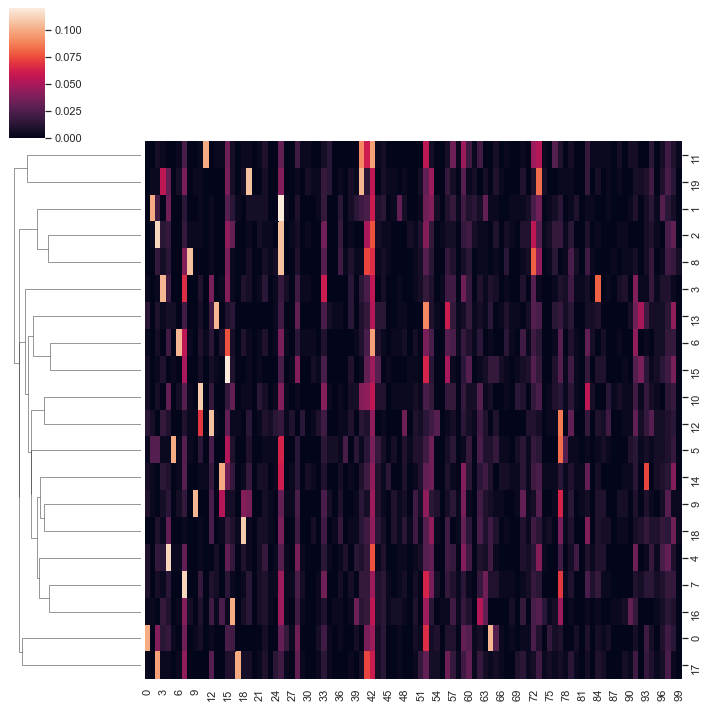

In [159]:
freq = np.zeros((n_clients, n_tokens))
for i in range(n_tokens):
    freq[:,i] = torch.sum(clients == i, dim=[1,2]).detach().numpy()
freq /= (n_sentences * n_tokens_p_sentences)
sns.clustermap(freq, col_cluster=False)
plt.show()

In [199]:
loss_fn = nn.NLLLoss()
n_steps = 1000
batch_size = 10
lr = 0.01

In [200]:
all_steps = [[[] for _ in range(n_steps)] for _ in range(n_clients)]
losses = [[] for _ in range(n_clients)]
acc = [[] for _ in range(n_clients)]

final_models = []
for client in range(n_clients):
    print(client)
    model = RNN(n_tokens, embedding_dim, hidden_dim-10, batch_size)
    optimizer = optim.Adam(lr=lr, params=model.parameters())

    for step in range(n_steps):
        for name, param in model.named_parameters():
            all_steps[client][step].extend(list(param.view(-1).detach().numpy()))
        
        batch_idx = np.random.choice(range(n_sentences), batch_size)
        X,Y = clients[client][batch_idx,:-1], clients[client][batch_idx,1:]
        optimizer.zero_grad()
        predict = model(X)
        loss = loss_fn(predict.reshape(-1, n_tokens), Y.reshape(-1))
        loss.backward()
        optimizer.step()
        
        acc[client].append(torch.sum(torch.argmax(predict, dim=2) == Y).item() / (X.shape[0] * X.shape[1]))
        losses[client].append(loss.item())
    final_models.append(model)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [26]:
n_model_params = sum([param.reshape(-1).shape[0] for param in model.parameters()])

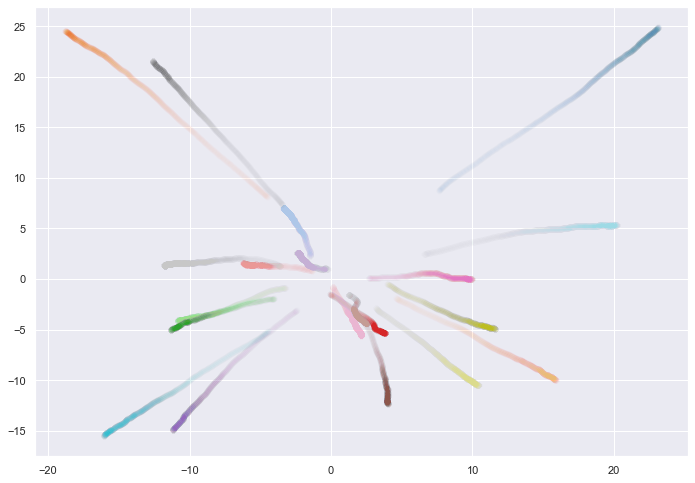

In [27]:
step_matrix = torch.tensor(all_steps).reshape(-1, n_model_params)
pca = PCA(n_components=2)

x = pca.fit_transform(step_matrix)
for i, color in zip(range(n_clients), (plt.get_cmap('tab20').colors * 10)[:n_clients]):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.scatterplot(x[i*n_steps:(i+1)*n_steps,0], x[i*n_steps:(i+1)*n_steps,1],alpha=0.01,color=color, linewidth=0)
#plt.legend()
plt.show()

In [28]:
runs = pd.DataFrame(columns = ['client', 'step', 'loss', 'accuracy'])
runs['client'] = [i for i in range(n_clients) for _ in range(n_steps)]
runs['step'] = list(range(n_steps)) * n_clients
runs['loss'] = np.array(losses).reshape(-1)
runs['loss_smooth'] = runs['loss'].rolling(40).mean() 
runs['accuracy'] = np.array(acc).reshape(-1)
runs['accuracy_smooth'] = runs['accuracy'].rolling(40).mean()

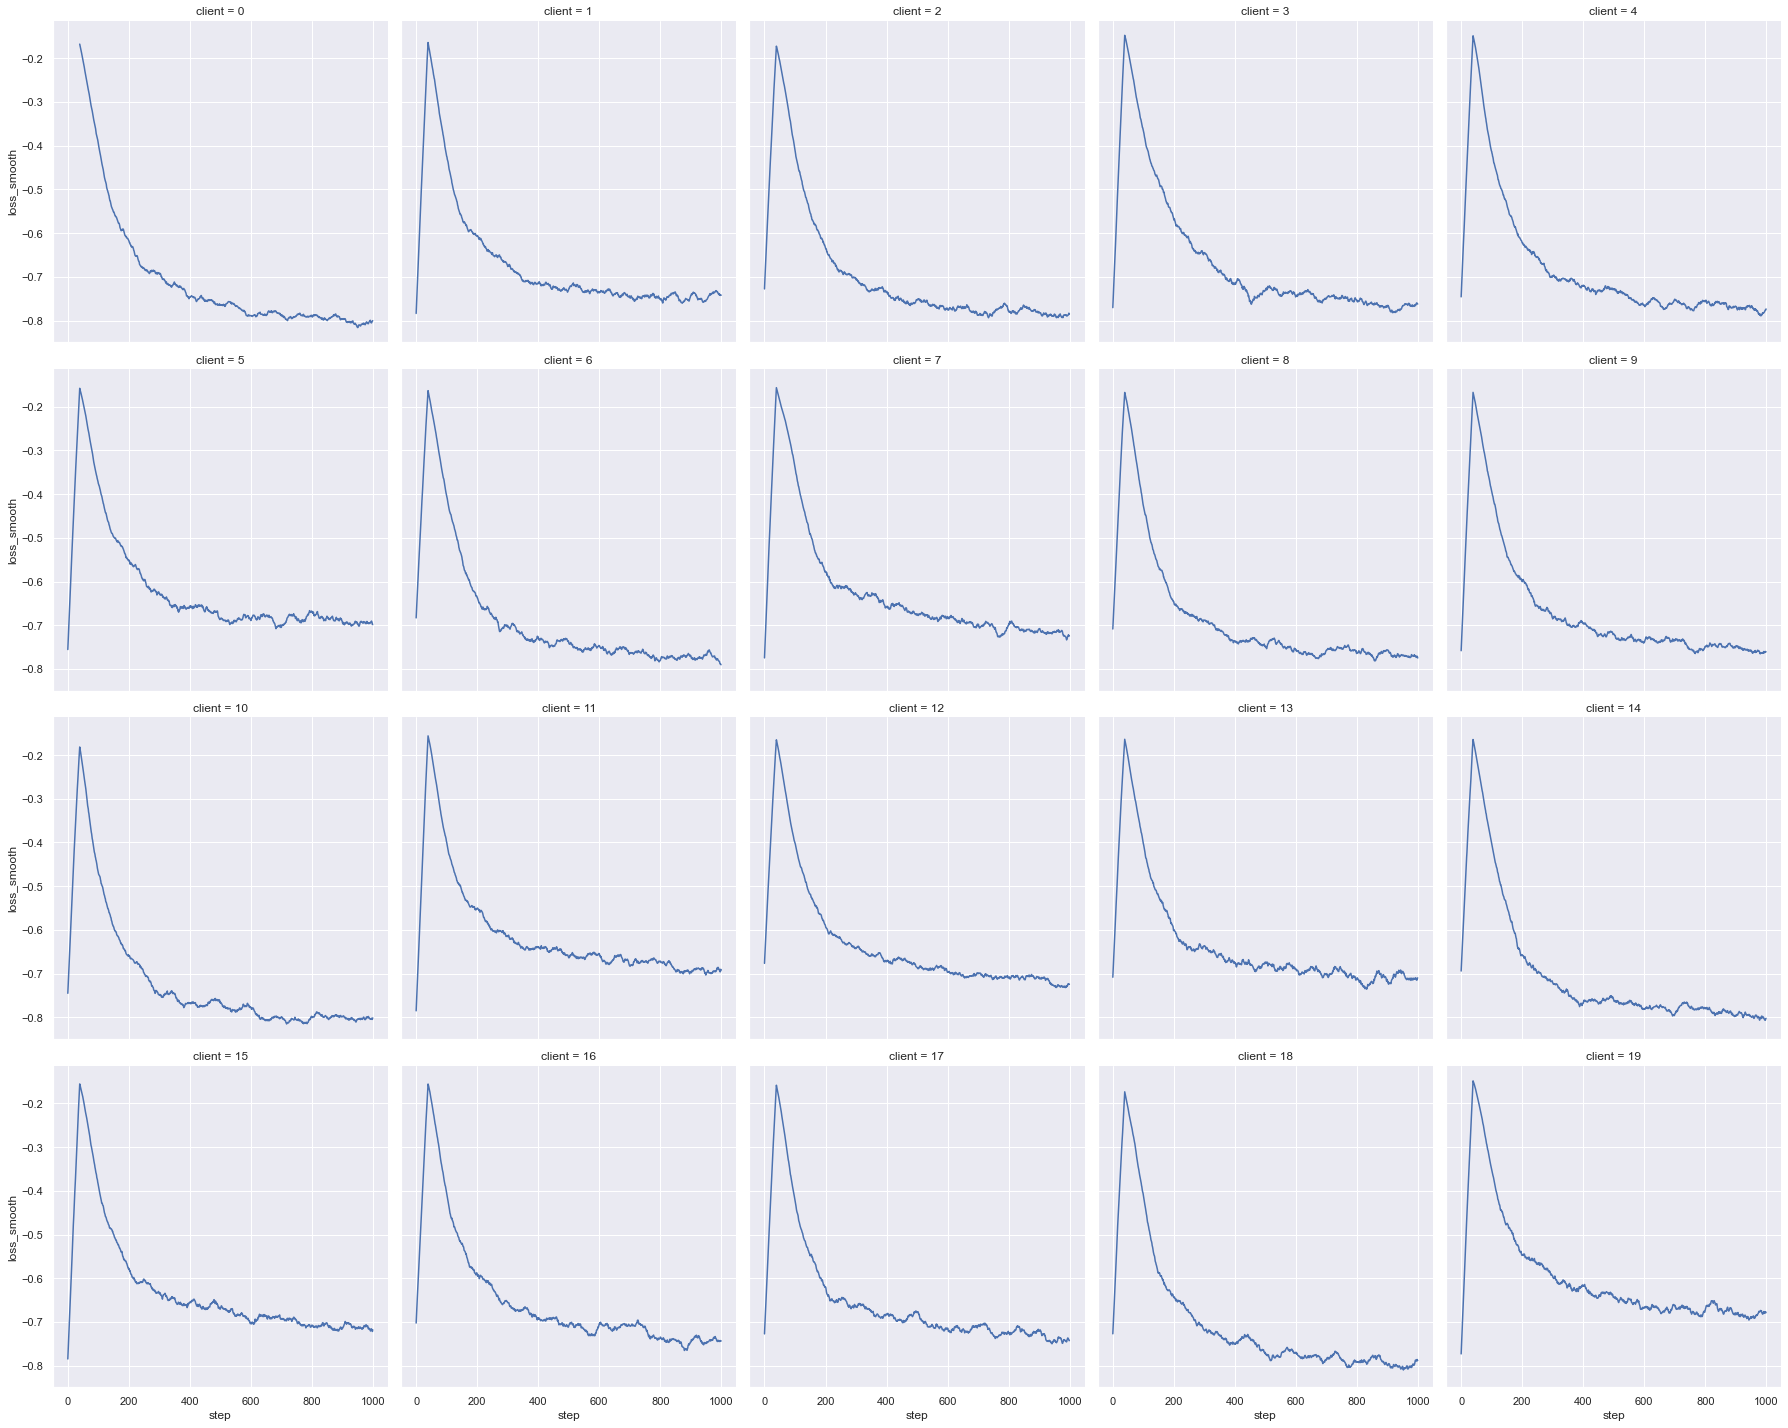

In [29]:
sns.relplot(x="step", y="loss_smooth", col="client", kind="line", data=runs, col_wrap=5)

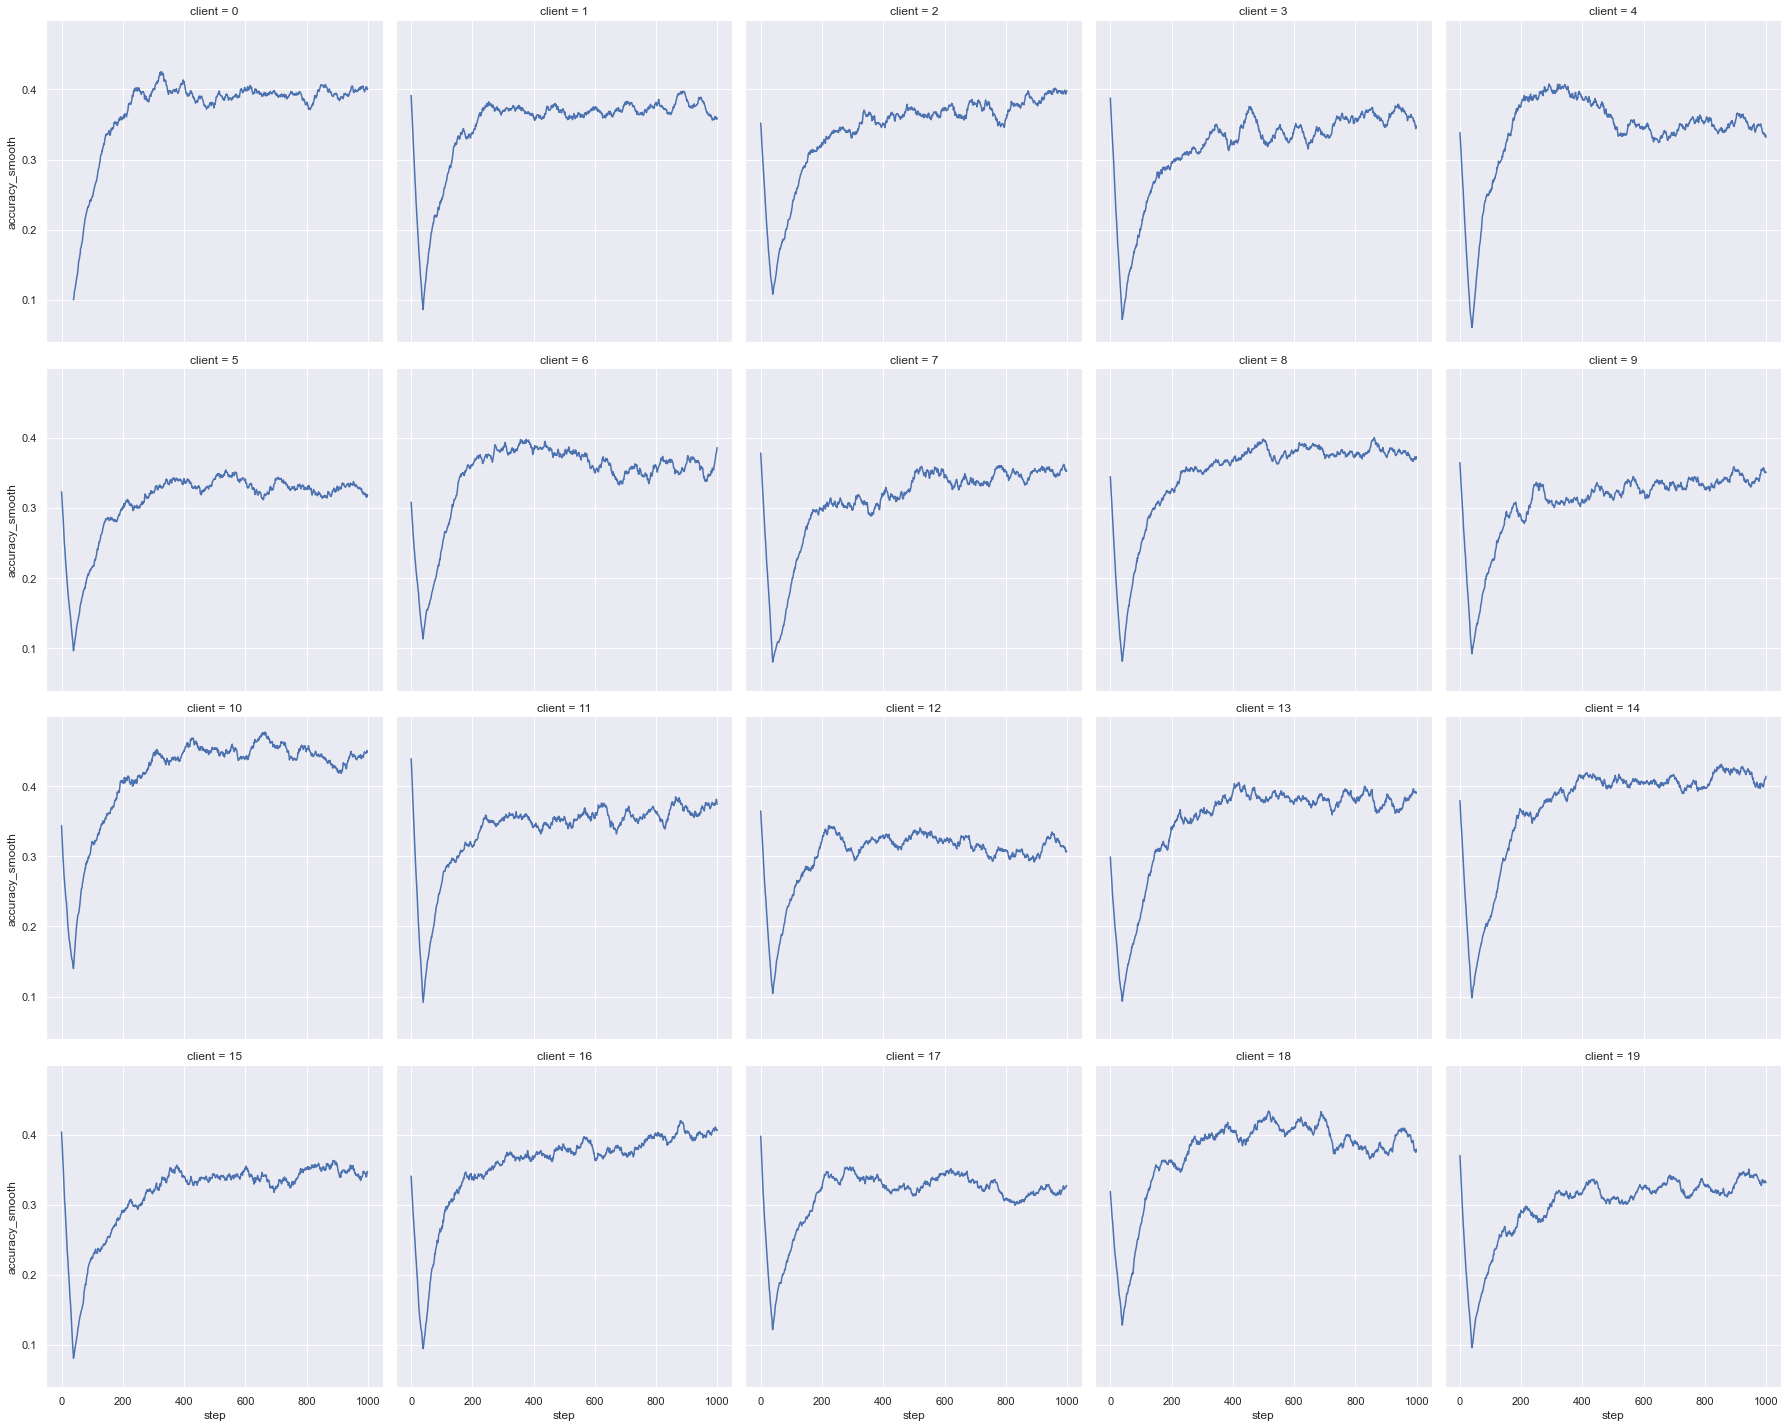

In [31]:
sns.relplot(x="step", y="accuracy_smooth", col="client", kind="line", data=runs, col_wrap=5)

In [64]:
loss_fn = nn.NLLLoss()
batch_size = 10
n_rounds = 1000
n_steps = 20
lr = 0.1

In [65]:
n_sever_params = sum([len(param.reshape(-1)) for param in RNN(n_tokens, embedding_dim, hidden_dim, batch_size).parameters()])

In [66]:
%%time 
#all_steps = [[[[] for _ in range(n_steps)] for _ in range(n_clients)] for _ in range(n_rounds)]
losses = [[] for _ in range(n_clients)]
acc = [[] for _ in range(n_clients)]

server_model_params = [[] for _ in range(n_rounds+1)]
model_per_round = []
server_model_losses = []

server_model = RNN(n_tokens, embedding_dim, hidden_dim, batch_size)
zero_model = copy(server_model).zero()

for name, param in server_model.named_parameters():
    server_model_params[0].extend(list(param.view(-1).detach().numpy()))
model_per_round.append(copy(server_model))
    
for round in range(n_rounds):
    print(round)
    client_models = []
    server_model_loss = 0
    for client in range(n_clients):
        client_model = copy(server_model)
        optimizer = optim.Adam(lr=lr, params=client_model.parameters())
        for step in range(n_steps):
            optimizer.zero_grad()
            # log params
#             for name, param in client_model.named_parameters():
#                 all_steps[round][client][step].extend(list(param.view(-1).detach().numpy()))
                
            # step of sgd
            batch_idx = np.random.choice(range(n_sentences), batch_size)
            X,Y = clients[client][batch_idx,:-1], clients[client][batch_idx,1:]
            optimizer.zero_grad()
            predict = client_model(X)
            loss = loss_fn(predict.reshape(-1, n_tokens), Y.reshape(-1))
            loss.backward()
            optimizer.step()
            # log metricst
            if step == 0:
                server_model_loss += loss
    
            acc[client].append(torch.sum(torch.argmax(predict, dim=2) == Y).item() / (X.shape[0] * X.shape[1]))
            losses[client].append(loss.item())
        client_models.append(client_model)

    server_model_losses.append(server_model_loss / n_clients)
    # average model
    server_model = sum(client_models, zero_model) / n_clients
    model_per_round.append(copy(server_model))
    for name, param in server_model.named_parameters():
        server_model_params[round+1].extend(list(param.view(-1).detach().numpy()))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [55]:
step_matrix = torch.tensor(all_steps).reshape(-1, n_sever_params)
pca = PCA(n_components=2)

x = pca.fit_transform(step_matrix)
sns.scatterplot(x[:,0], x[:,1],alpha=0.1,color=color, linewidth=0)
#plt.legend()
plt.show()

ValueError: expected sequence of length 1650 at dim 2 (got 0)

In [67]:
server_model_losses_lr_0_1_s_20 = server_model_losses

## lr = 0.1

/Users/shashwatdalal/.local/share/virtualenvs/niid_test-Meyna6jB/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
/Users/shashwatdalal/.local/share/virtualenvs/niid_test-Meyna6jB/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
/Users/shashwatdalal/.local/share/virtualenvs/niid_test-Meyna6jB/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
/Users/shashwatdalal/.local/share/virtualenvs/niid_test

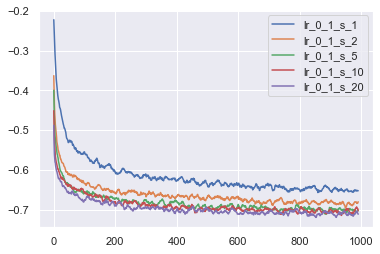

In [68]:
for exp, label in zip([server_model_losses_lr_0_1_s_1,server_model_losses_lr_0_1_s_2,server_model_losses_lr_0_1_s_5,server_model_losses_lr_0_1_s_10,server_model_losses_lr_0_1_s_20],['lr_0_1_s_1','lr_0_1_s_2','lr_0_1_s_5','lr_0_1_s_10','lr_0_1_s_20']):
    plt.plot(moving_average(np.array(exp)), label=label)
    np.save('cluster_2/{}'.format(label), np.array(exp))
plt.legend()

## Lr = 0.01

In [15]:
server_model_losses_lr_0_01_s_1 = np.load('cluster_2/lr_0_01_s_1.npy', allow_pickle=True)

/Users/shashwatdalal/.local/share/virtualenvs/niid_test-Meyna6jB/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
/Users/shashwatdalal/.local/share/virtualenvs/niid_test-Meyna6jB/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
/Users/shashwatdalal/.local/share/virtualenvs/niid_test-Meyna6jB/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
/Users/shashwatdalal/.local/share/virtualenvs/niid_test

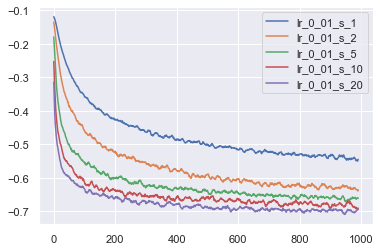

In [41]:
for exp, label in zip([server_model_losses_lr_0_01_s_1,server_model_losses_lr_0_01_s_2,server_model_losses_lr_0_01_s_5,server_model_losses_lr_0_01_s_10,server_model_losses_lr_0_01_s_20],['lr_0_01_s_1','lr_0_01_s_2','lr_0_01_s_5','lr_0_01_s_10','lr_0_01_s_20']):
    plt.plot(moving_average(np.array(exp)), label=label)
    np.save('cluster_2/{}'.format(label), np.array(exp))
plt.legend()

## lr = 0.001

/Users/shashwatdalal/.local/share/virtualenvs/niid_test-Meyna6jB/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
/Users/shashwatdalal/.local/share/virtualenvs/niid_test-Meyna6jB/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
/Users/shashwatdalal/.local/share/virtualenvs/niid_test-Meyna6jB/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
/Users/shashwatdalal/.local/share/virtualenvs/niid_test

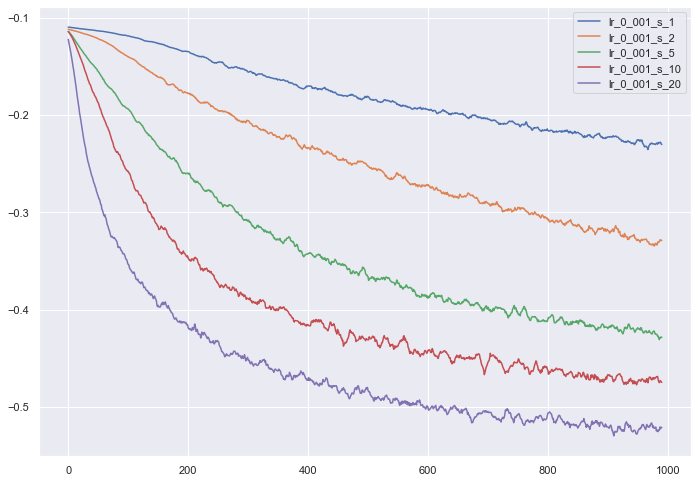

In [77]:
for exp, label in zip([server_model_losses_lr_0_001_s_1, server_model_losses_lr_0_001_s_2, server_model_losses_lr_0_001_s_5, server_model_losses_lr_0_001_s_10, server_model_losses_lr_0_001_s_20],
                      ['lr_0_001_s_1','lr_0_001_s_2','lr_0_001_s_5','lr_0_001_s_10','lr_0_001_s_20']):
    plt.plot(moving_average(np.array(exp)), label=label)
    np.save('cluster_2/{}'.format(label), np.array(exp))
plt.legend()

In [359]:
fig = r"""\begin{figure} 
 \centering"""
for eps in [1,2,5,10]:
    for lr in ["1","01","001"]:
        fig += r"""
        \begin{{subfigure}}{{0.33\textwidth}}
        \centering
            \includegraphics[width=\linewidth]{{Results/epsf{}lr0_{}.png}}
            \caption{{\texttt{{SyntheticSeq}}$(1,{})  \\ l=0.{}$}}
            \label{{fig:fepsc{}lr0_{}}}
        \end{{subfigure}}%""".format(eps,lr,eps,lr,eps,lr)
    fig += r"""
    \\"""
fig+=r"""
\caption{Effect of different \texttt{FedAvg} paramters for data generated by \texttt{{SyntheticSeq}}$(1,\epsilon)$ on $\Omega$ for various $\epsilon$}
\end{figure}"""

In [360]:
omega = np.zeros((5, 901))
for i, exp in enumerate([server_model_losses_lr_0_1_s_1,server_model_losses_lr_0_1_s_2,server_model_losses_lr_0_1_s_5,server_model_losses_lr_0_1_s_10,server_model_losses_lr_0_1_s_20]):
    omega[i] = moving_average(exp, n=100) - avg_client_loss

In [361]:
print(fig)

\begin{figure} 
 \centering
        \begin{subfigure}{0.33\textwidth}
        \centering
            \includegraphics[width=\linewidth]{Results/epsf1lr0_1.png}
            \caption{\texttt{SyntheticSeq}$(1,1)  \\ l=0.1$}
            \label{fig:fepsc1lr0_1}
        \end{subfigure}%
        \begin{subfigure}{0.33\textwidth}
        \centering
            \includegraphics[width=\linewidth]{Results/epsf1lr0_01.png}
            \caption{\texttt{SyntheticSeq}$(1,1)  \\ l=0.01$}
            \label{fig:fepsc1lr0_01}
        \end{subfigure}%
        \begin{subfigure}{0.33\textwidth}
        \centering
            \includegraphics[width=\linewidth]{Results/epsf1lr0_001.png}
            \caption{\texttt{SyntheticSeq}$(1,1)  \\ l=0.001$}
            \label{fig:fepsc1lr0_001}
        \end{subfigure}%
    \\
        \begin{subfigure}{0.33\textwidth}
        \centering
            \includegraphics[width=\linewidth]{Results/epsf2lr0_1.png}
            \caption{\texttt{SyntheticSeq}$(1,2)  \\ l=0.1$}
 

In [362]:
print(server_model)

RNN(
  (E): Embedding(100, 5)
  (rnn): RNN(5, 20, bias=False)
  (W_ho): Linear(in_features=20, out_features=100, bias=False)
  (softmax): Softmax(dim=1)
)
